In [58]:
%pip install nltk transformers torch annoy seaborn matplotlib scikit-learn PyPDF2


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [59]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from annoy import AnnoyIndex
import PyPDF2
import os
from tqdm import tqdm


nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aayushgupta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aayushgupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [60]:
#LOADING THE FILE TEXT IN

def read_pdf(file_path):
    with open(file_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        text = " ".join([page.extract_text() for page in pdf_reader.pages if page.extract_text() is not None])
    return text




In [61]:
#PREPROCESSING THE TEXT

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return filtered_words


In [74]:
from collections import defaultdict

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

# Modify the embedding function for batch processing
def embed_words_batch(words):
    inputs = tokenizer(words, padding=True, return_tensors='pt', truncation=True)
    outputs = model(**inputs)
    return outputs.hidden_states[-1][:, 0, :].detach().numpy()

# Creating embeddings with caching and batch processing
def create_embedding_dictionary_batch(file_path, batch_size=10):
    document_text = read_pdf(file_path)
    words = preprocess_text(document_text)
    unique_words = list(set(words))  # Unique words for caching

    # Caching embeddings
    cached_embeddings = defaultdict(lambda: None)
    embeddings_dict = {}

    for i in range(0, len(unique_words), batch_size):
        batch_words = unique_words[i:i+batch_size]
        batch_embeddings = embed_words_batch(batch_words)

        for word, embedding in zip(batch_words, batch_embeddings):
            cached_embeddings[word] = embedding

    for word in words:
        embeddings_dict[word] = {
            'embedding': cached_embeddings[word],
            'file': file_path
        }

    return embeddings_dict


def process_multiple_pdfs(folder_path, n, batch=10):
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.pdf')]
    processed_files = all_files[:n]  # Process only the first n files

    all_embeddings = {}
    for file in tqdm(processed_files, desc="Processing PDFs"):
        file_path = os.path.join(folder_path, file)
        try:
            embeddings_dict = create_embedding_dictionary_batch(file_path, batch)
            all_embeddings.update(embeddings_dict)
        except Exception as e:  # Catching a more general exception
            print(f"Error reading PDF: {file}. Skipping this file.")
            continue

    return all_embeddings

In [63]:
def build_annoy_index(embeddings_dict):
    f = list(embeddings_dict.values())[0]['embedding'].shape[0]
    t = AnnoyIndex(f, 'angular')
    for i, (word, data) in enumerate(embeddings_dict.items()):
        t.add_item(i, data['embedding'])
    t.build(10)
    return t

def query_similar_words(query, index, embeddings_dict, top_n=5):
    query_embedding = embed_words_batch([query])[0]  # Embed the query word
    nearest_ids = index.get_nns_by_vector(query_embedding, top_n)

    similar_words_with_titles = []
    for i in nearest_ids:
        word = list(embeddings_dict.keys())[i]
        title = embeddings_dict[word]['file'].split('/')[-1]  # Extract the file name
        similar_words_with_titles.append((word, title))

    return similar_words_with_titles



In [75]:
folder_path = '/Users/aayushgupta/Downloads/arxivPDFs'
num_papers_to_process = 15  # Replace with the number of papers you want to process

embeddings_dict = process_multiple_pdfs(folder_path, num_papers_to_process, 40)


# # Create embeddings dictionary
# filepath = 'path'
# embeddings_dict = create_embedding_dictionary_batch(file_path, 40)

Processing PDFs:  47%|████▋     | 7/15 [00:44<00:57,  7.13s/it]

Error reading PDF: 2011.03426v2.pdf. Skipping this file.


Processing PDFs: 100%|██████████| 15/15 [02:27<00:00,  9.85s/it]


In [77]:
# Build Annoy index
annoy_index = build_annoy_index(embeddings_dict)

In [79]:
# Query for similar words
query_word = "prompt engieering technique"  # Replace with your query word
similar_words = query_similar_words(query_word, annoy_index, embeddings_dict, top_n=25)
print(f"Words similar to '{query_word}': {similar_words}")

Words similar to 'chain-of-thought': [('chain-of-thought', '2310.01441v1.pdf'), ('Chain-of-thought', '2310.01441v1.pdf'), ('Chain-of-Thought', '2310.01441v1.pdf'), ('of-thought', '2305.04039v1.pdf'), ('of-Thought', '2311.03837v1.pdf'), ('Always-use', '2302.12813v3.pdf'), ('by-step', '2302.12813v3.pdf'), ('feedbacks', '2302.12813v3.pdf'), ('task-speciﬁc', '2302.12813v3.pdf'), ('Task-speciﬁc', '2102.07350v1.pdf'), ('med-PaLM', '2306.07170v1.pdf'), ('cutting-edge', '2305.04039v1.pdf'), ('TypeLiving-with_family', '2306.07170v1.pdf'), ('example_target_phrase', '2102.07350v1.pdf'), ('causality', '2310.01441v1.pdf'), ('instruct-v20.914', '2311.03837v1.pdf'), ('schemas', '2210.06656v1.pdf'), ('learner', '2308.09890v1.pdf'), ('acronyms', '2304.06939v3.pdf'), ('heuristics', '2302.12813v3.pdf'), ('Heuristics', '2306.07170v1.pdf'), ('out-of-the-box', '2311.03837v1.pdf'), ('standoffGPT-', '2306.07170v1.pdf'), ('three-sentence', '2304.06939v3.pdf'), ('v3-v3.5', '2303.17276v1.pdf')]


In [67]:
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans

def optimized_plot_embeddings(embeddings_dict, query, index, top_n=5):
    # Extract existing embeddings and the query embedding from the dictionary
    words, embeddings = zip(*[(word, data['embedding']) for word, data in embeddings_dict.items() if data['embedding'] is not None])
    query_embedding = embeddings_dict.get(query, {'embedding': None})['embedding']
    
    # Handle case where query embedding is not pre-computed
    if query_embedding is None:
        query_embedding = embed_words_batch([query])[0]

    extended_embeddings = np.vstack(embeddings + (query_embedding,))
    
    # TSNE for dimensionality reduction (can be cached for the same dataset)
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(extended_embeddings)

    # KMeans for clustering (can be cached for the same dataset)
    kmeans = KMeans(n_clusters=5)
    clusters = kmeans.fit_predict(extended_embeddings)

    # Find nearest neighbors using the pre-built index
    indices = index.get_nns_by_vector(query_embedding, top_n)

    # Plotting
    sns.set(style='whitegrid')
    plt.figure(figsize=(12, 8))

    # Plot all points with cluster coloring
    plt.scatter(tsne_results[:-1, 0], tsne_results[:-1, 1], c=clusters[:-1], alpha=0.5, cmap='viridis')

    # Highlight the query point
    plt.scatter(tsne_results[-1, 0], tsne_results[-1, 1], color='blue', marker='X')

    # Highlight nearest neighbors with red outline
    for i in indices:
        plt.scatter(tsne_results[i, 0], tsne_results[i, 1], facecolors='none', edgecolors='red', s=100)
        plt.annotate(words[i], (tsne_results[i, 0], tsne_results[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')

    # Label the query
    plt.annotate("Query", (tsne_results[-1, 0], tsne_results[-1, 1]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title('Optimized t-SNE Visualization of Word Embeddings with Query and Nearest Neighbors')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5728 samples in 0.001s...
[t-SNE] Computed neighbors for 5728 samples in 0.634s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5728
[t-SNE] Computed conditional probabilities for sample 2000 / 5728
[t-SNE] Computed conditional probabilities for sample 3000 / 5728
[t-SNE] Computed conditional probabilities for sample 4000 / 5728
[t-SNE] Computed conditional probabilities for sample 5000 / 5728
[t-SNE] Computed conditional probabilities for sample 5728 / 5728
[t-SNE] Mean sigma: 1.240647
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.637543
[t-SNE] KL divergence after 300 iterations: 2.692585


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


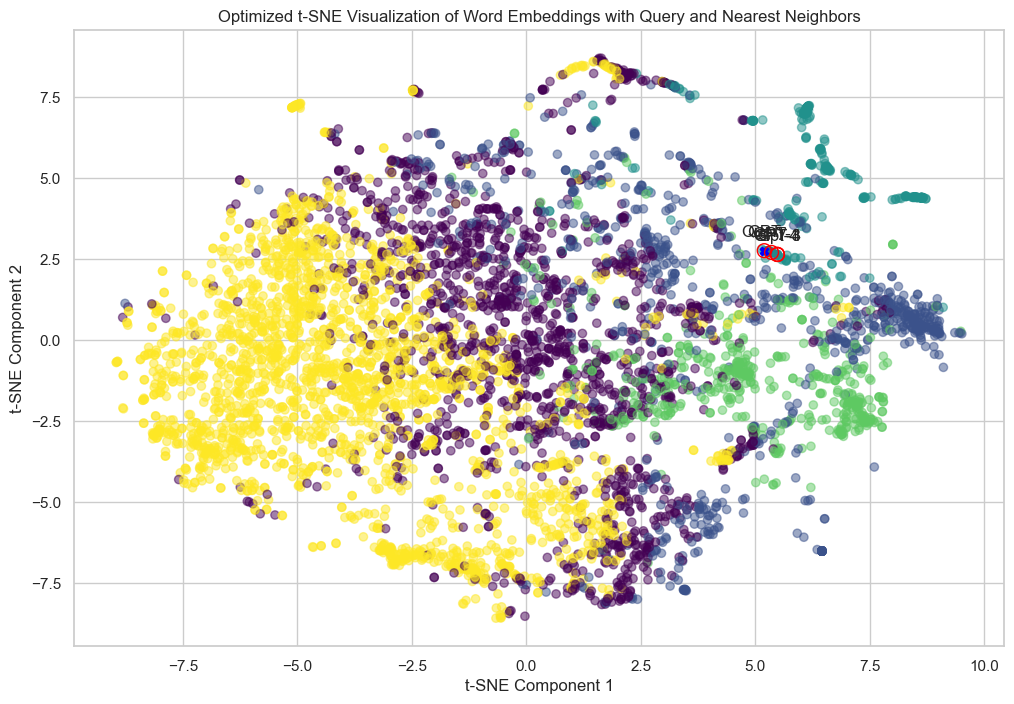

In [68]:
# Example query word
query_word = "gpt"  # Replace with your query word

# Plotting the embeddings assuming all previous steps have been completed
optimized_plot_embeddings(embeddings_dict, query_word, annoy_index, top_n=5)
